<a href="https://colab.research.google.com/github/simasaadi/canada-climate-80yrs/blob/main/04_extremes_indices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 04 — Climate Extremes & Derived Indicators (Canadian Climate, 1940–Present)

This notebook derives extreme-climate indicators from the processed daily dataset, including:
- heat/cold extremes based on baseline percentiles
- heavy precipitation days and precipitation intensity
- freeze-related indicators and event counts
Outputs are saved to `reports/extremes/` for downstream use in dashboards and reporting.


In [21]:
import os
from pathlib import Path
import pandas as pd
import numpy as np

os.chdir("/content")

REPO_DIR = Path("/content/canada-climate-80yrs")
RAW_DIR = REPO_DIR / "data" / "raw"
PROCESSED_DIR = REPO_DIR / "data" / "processed"

RAW_PATH = RAW_DIR / "canadian_climate_daily.csv"  # this is what your repo actually has
TIDY_PATH = PROCESSED_DIR / "climate_daily_tidy.parquet"
MONTHLY_PATH = PROCESSED_DIR / "climate_monthly.parquet"
YEARLY_PATH = PROCESSED_DIR / "climate_yearly.parquet"

print("Repo:", REPO_DIR.exists())
print("Raw:", RAW_PATH.exists(), RAW_PATH)
print("Processed dir:", PROCESSED_DIR.exists(), PROCESSED_DIR)
print("Tidy:", TIDY_PATH.exists())
print("Monthly:", MONTHLY_PATH.exists())
print("Yearly:", YEARLY_PATH.exists())


Repo: True
Raw: True /content/canada-climate-80yrs/data/raw/canadian_climate_daily.csv
Processed dir: True /content/canada-climate-80yrs/data/processed
Tidy: True
Monthly: True
Yearly: True


In [23]:
df = pd.read_parquet(TIDY_PATH)

df["local_date"] = pd.to_datetime(df["local_date"])
df["city"] = df["city"].astype(str).str.upper().str.strip()

for col in ["mean_temperature", "total_precipitation"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df["year"] = df["local_date"].dt.year
df["month"] = df["local_date"].dt.month

print(df.shape)
df.head(3)


(355513, 9)


,local_date,city,mean_temperature,total_precipitation,year,month,dayofyear,is_freezing,precip_positive
0,1940-01-01,CALGARY,-11.4,0.5,1940,1,1,True,True
1,1940-01-01,MONCTON,-8.9,0.0,1940,1,1,True,False
2,1940-01-01,OTTAWA,-17.0,0.0,1940,1,1,True,False


In [24]:
MIN_DAYS_PER_YEAR = 300

coverage = (
    df.groupby(["city", "year"], as_index=False)
      .agg(n_obs=("mean_temperature", "count"))
)

eligible_years = coverage[coverage["n_obs"] >= MIN_DAYS_PER_YEAR]

df = df.merge(
    eligible_years[["city", "year"]],
    on=["city", "year"],
    how="inner"
)

print("After coverage filter:", df.shape)


After coverage filter: (353740, 9)


In [25]:
BASELINE = (1961, 1990)

baseline = df[
    (df["year"] >= BASELINE[0]) &
    (df["year"] <= BASELINE[1])
]

thresholds = (
    baseline.groupby("city")["mean_temperature"]
    .quantile([0.05, 0.95])
    .unstack()
    .rename(columns={0.05: "t_p05", 0.95: "t_p95"})
    .reset_index()
)

thresholds


,city,t_p05,t_p95
0,CALGARY,-18.6,18.60
1,EDMONTON,-22.3,18.10
2,HALIFAX,-10.3,20.20
3,MONCTON,-13.5,20.30
4,MONTREAL,-15.0,22.80
5,OTTAWA,-15.5,22.80
6,QUEBEC,-16.7,20.90
7,SASKATOON,-24.5,20.90
8,STJOHNS,-8.4,17.92
9,TORONTO,-11.1,22.70


In [26]:
df = df.merge(thresholds, on="city", how="left")

df["cold_extreme"] = df["mean_temperature"] <= df["t_p05"]
df["hot_extreme"]  = df["mean_temperature"] >= df["t_p95"]

df[["city", "local_date", "mean_temperature", "cold_extreme", "hot_extreme"]].head()


,city,local_date,mean_temperature,cold_extreme,hot_extreme
0,CALGARY,1940-01-01,-11.4,False,False
1,MONCTON,1940-01-01,-8.9,False,False
2,OTTAWA,1940-01-01,-17.0,True,False
3,SASKATOON,1940-01-01,-25.6,True,False
4,TORONTO,1940-01-01,-8.9,False,False


In [27]:
extremes_annual = (
    df.groupby(["city", "year"], as_index=False)
      .agg(
          cold_days=("cold_extreme", "sum"),
          hot_days=("hot_extreme", "sum"),
          n_days=("mean_temperature", "count")
      )
)

extremes_annual.head()


,city,year,cold_days,hot_days,n_days
0,CALGARY,1940,16,15,366
1,CALGARY,1941,12,26,365
2,CALGARY,1942,11,15,365
3,CALGARY,1943,23,17,365
4,CALGARY,1944,3,9,366


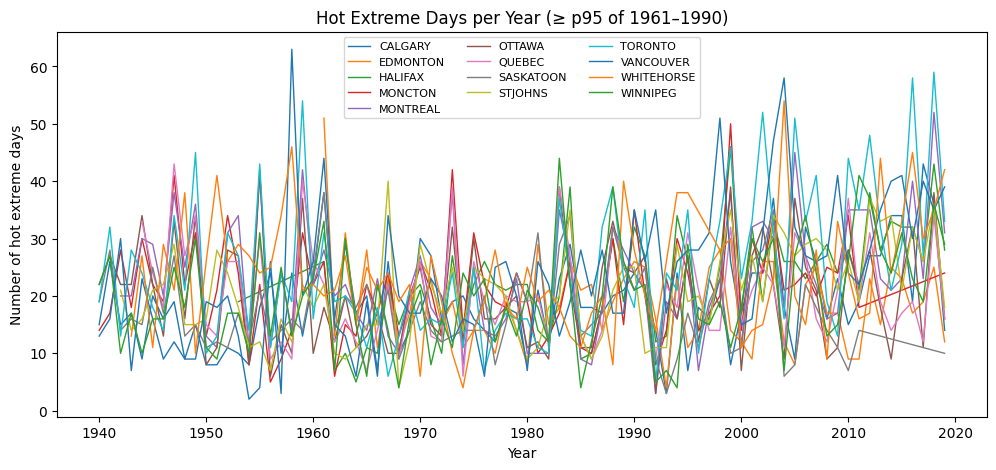

In [28]:
cities = sorted(extremes_annual["city"].unique())

fig, ax = plt.subplots(figsize=(12, 5))

for c in cities:
    s = extremes_annual[extremes_annual["city"] == c].sort_values("year")
    ax.plot(s["year"], s["hot_days"], linewidth=1, label=c)

ax.set_title(f"Hot Extreme Days per Year (≥ p95 of {BASELINE[0]}–{BASELINE[1]})")
ax.set_xlabel("Year")
ax.set_ylabel("Number of hot extreme days")
ax.legend(ncol=3, fontsize=8)
plt.show()


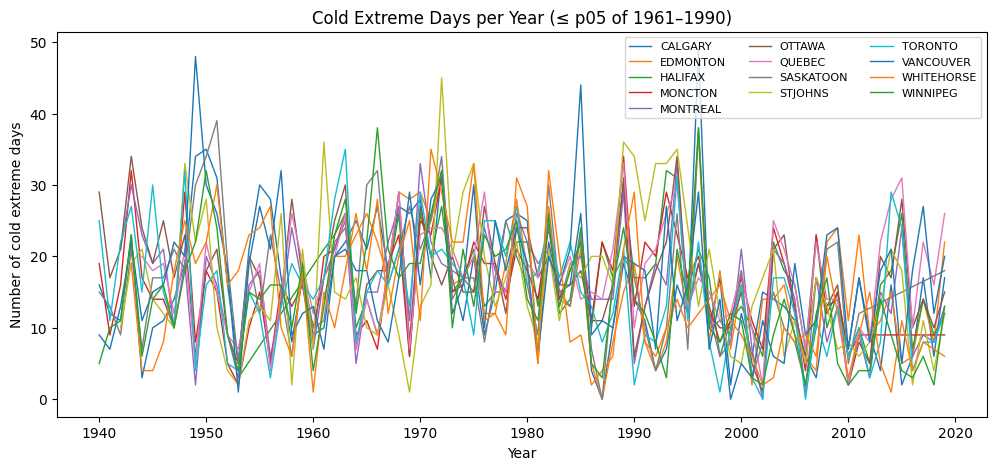

In [29]:
fig, ax = plt.subplots(figsize=(12, 5))

for c in cities:
    s = extremes_annual[extremes_annual["city"] == c].sort_values("year")
    ax.plot(s["year"], s["cold_days"], linewidth=1, label=c)

ax.set_title(f"Cold Extreme Days per Year (≤ p05 of {BASELINE[0]}–{BASELINE[1]})")
ax.set_xlabel("Year")
ax.set_ylabel("Number of cold extreme days")
ax.legend(ncol=3, fontsize=8)
plt.show()


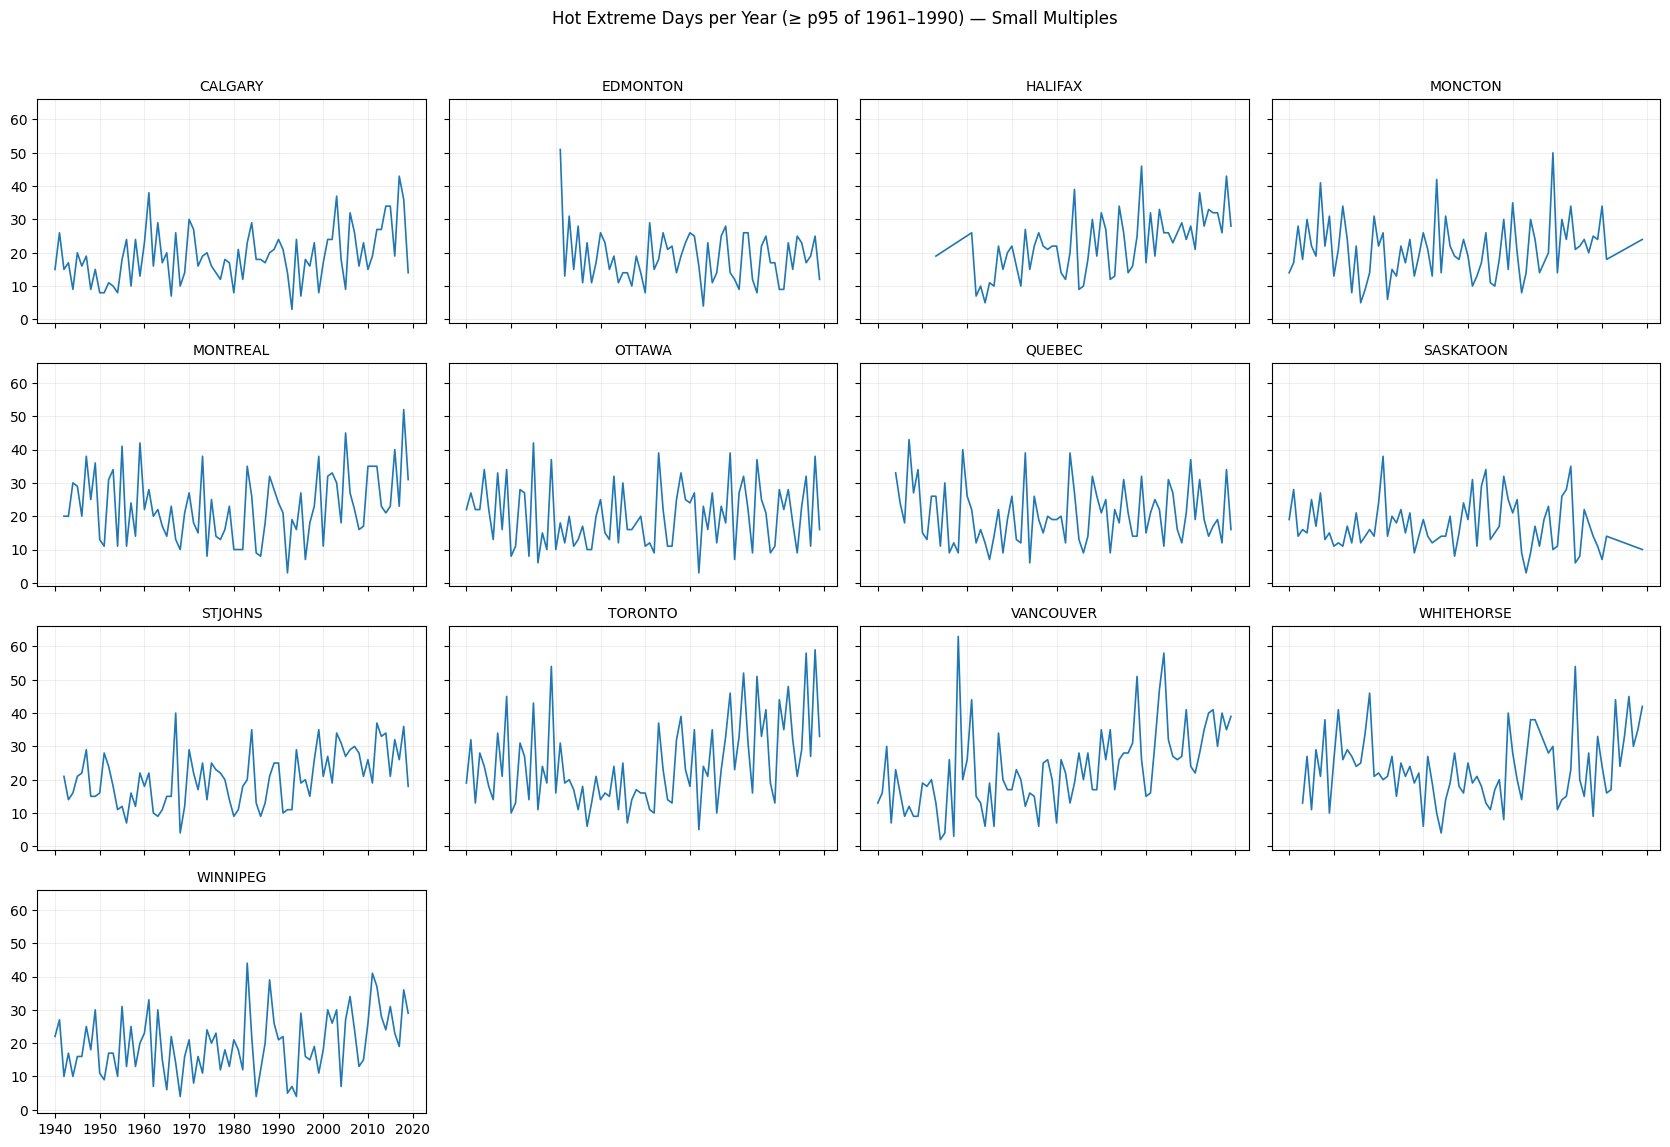

In [34]:
import math
import matplotlib.pyplot as plt

cities = sorted(extremes_annual["city"].unique())
n = len(cities)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*4.2, rows*2.8), sharex=True, sharey=True)
axes = axes.flatten()

for i, c in enumerate(cities):
    ax = axes[i]
    s = extremes_annual[extremes_annual["city"] == c].sort_values("year")
    ax.plot(s["year"], s["hot_days"], linewidth=1.2)
    ax.set_title(c, fontsize=10)
    ax.grid(True, alpha=0.2)

for j in range(i+1, len(axes)):
    axes[j].axis("off")

fig.suptitle(f"Hot Extreme Days per Year (≥ p95 of {BASELINE[0]}–{BASELINE[1]}) — Small Multiples", y=1.02)
plt.tight_layout()
plt.show()


/tmp/ipython-input-2150452103.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=order, vert=True, showfliers=False)


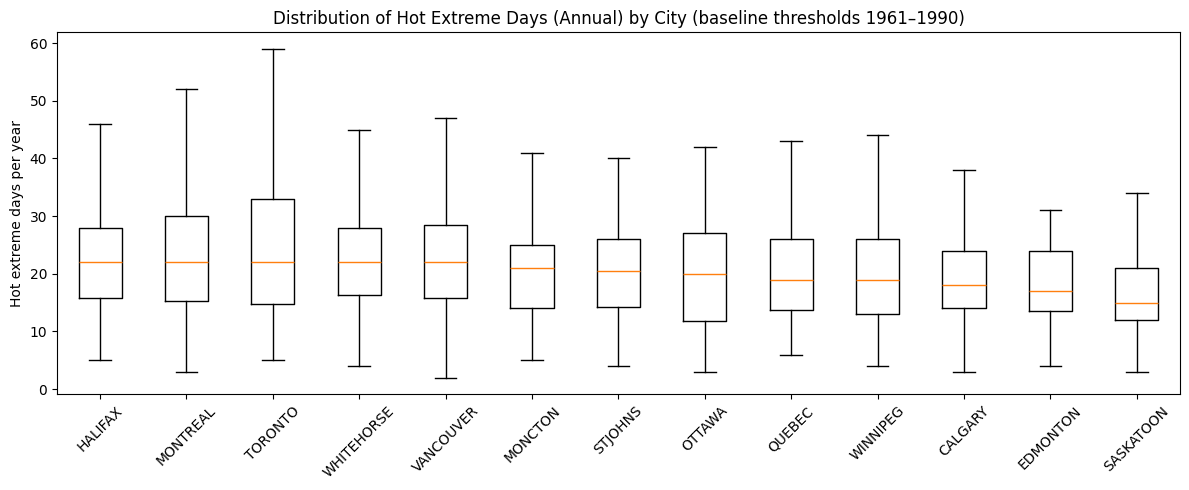

In [35]:
order = (
    extremes_annual.groupby("city")["hot_days"]
    .median()
    .sort_values(ascending=False)
    .index.tolist()
)

data = [extremes_annual.loc[extremes_annual["city"] == c, "hot_days"].dropna().values for c in order]

fig, ax = plt.subplots(figsize=(12, 5))
ax.boxplot(data, labels=order, vert=True, showfliers=False)
ax.set_title(f"Distribution of Hot Extreme Days (Annual) by City (baseline thresholds {BASELINE[0]}–{BASELINE[1]})")
ax.set_ylabel("Hot extreme days per year")
ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()


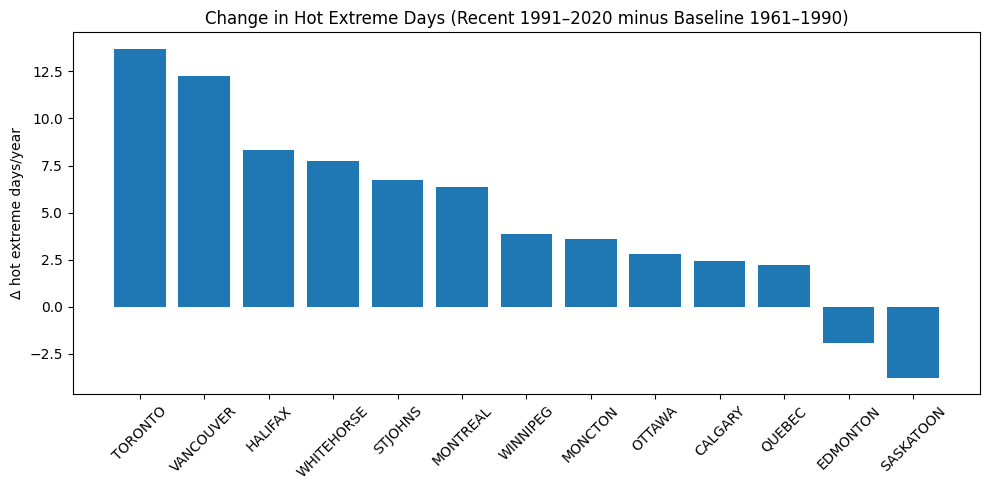

,delta_hot_days_recent_minus_baseline
city,
TORONTO,13.702299
VANCOUVER,12.259770
HALIFAX,8.326437
WHITEHORSE,7.756410
STJOHNS,6.733333
MONTREAL,6.385057
WINNIPEG,3.875862
MONCTON,3.593939
OTTAWA,2.804598


In [36]:
RECENT = (1991, 2020)

def period_mean(df, y0, y1, col):
    sub = df[(df["year"] >= y0) & (df["year"] <= y1)]
    return sub.groupby("city")[col].mean()

hot_base = period_mean(extremes_annual, BASELINE[0], BASELINE[1], "hot_days")
hot_recent = period_mean(extremes_annual, RECENT[0], RECENT[1], "hot_days")

delta_hot = (hot_recent - hot_base).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(delta_hot.index, delta_hot.values)
ax.set_title(f"Change in Hot Extreme Days (Recent {RECENT[0]}–{RECENT[1]} minus Baseline {BASELINE[0]}–{BASELINE[1]})")
ax.set_ylabel("Δ hot extreme days/year")
ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

delta_hot.to_frame("delta_hot_days_recent_minus_baseline")


In [37]:
# Ensure these exist
d = df.copy()
d["wet_day"] = d["total_precipitation"] > 0

prec_ext = (
    d.groupby(["city", "year"], as_index=False)
     .agg(
         rx1day=("total_precipitation", "max"),
         wet_days=("wet_day", "sum"),
         prcptot=("total_precipitation", "sum")
     )
)

prec_ext["sdii"] = prec_ext["prcptot"] / prec_ext["wet_days"].replace(0, np.nan)  # Simple Daily Intensity Index proxy

prec_ext.head()


,city,year,rx1day,wet_days,prcptot,sdii
0,CALGARY,1940,29.2,119,456.7,3.837815
1,CALGARY,1941,37.3,101,392.1,3.882178
2,CALGARY,1942,55.1,120,522.5,4.354167
3,CALGARY,1943,23.4,89,336.3,3.778652
4,CALGARY,1944,38.6,106,432.9,4.083962


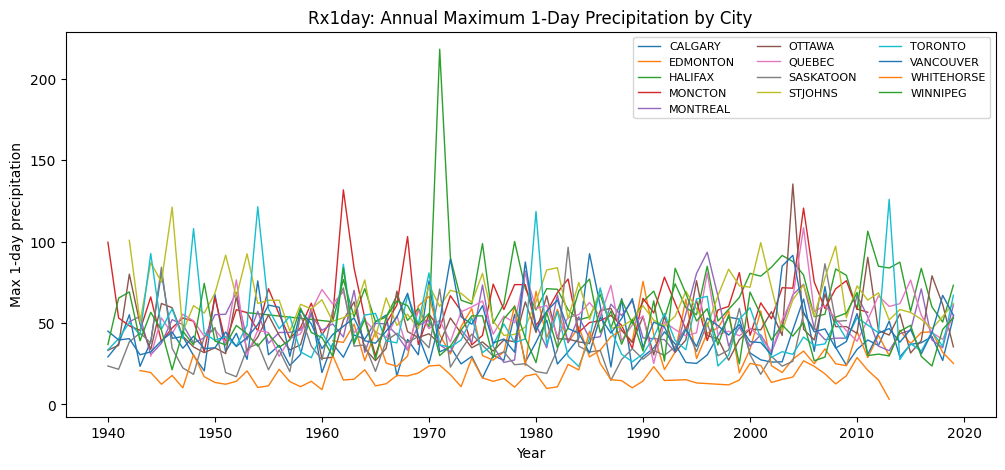

In [38]:
fig, ax = plt.subplots(figsize=(12, 5))
for c in cities:
    s = prec_ext[prec_ext["city"] == c].sort_values("year")
    ax.plot(s["year"], s["rx1day"], linewidth=1, label=c)

ax.set_title("Rx1day: Annual Maximum 1-Day Precipitation by City")
ax.set_xlabel("Year")
ax.set_ylabel("Max 1-day precipitation")
ax.legend(ncol=3, fontsize=8)
plt.show()


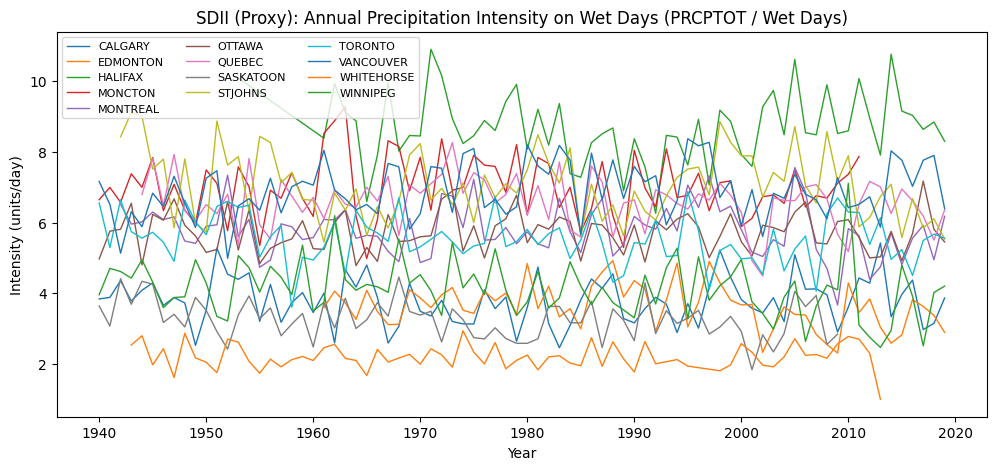

In [39]:
fig, ax = plt.subplots(figsize=(12, 5))
for c in cities:
    s = prec_ext[prec_ext["city"] == c].sort_values("year")
    ax.plot(s["year"], s["sdii"], linewidth=1, label=c)

ax.set_title("SDII (Proxy): Annual Precipitation Intensity on Wet Days (PRCPTOT / Wet Days)")
ax.set_xlabel("Year")
ax.set_ylabel("Intensity (units/day)")
ax.legend(ncol=3, fontsize=8)
plt.show()


In [40]:
OUT_DIR = REPO_DIR / "reports" / "extremes"
OUT_DIR.mkdir(parents=True, exist_ok=True)

extremes_annual.to_csv(OUT_DIR / "temp_extremes_annual.csv", index=False)
extreme_trends.to_csv(OUT_DIR / "temp_extremes_trends.csv", index=False)
prec_ext.to_csv(OUT_DIR / "precip_extremes_annual.csv", index=False)

print("Saved:")
for p in sorted(OUT_DIR.glob("*.csv")):
    print(" -", p)


Saved:
 - /content/canada-climate-80yrs/reports/extremes/extreme_days_annual.csv
 - /content/canada-climate-80yrs/reports/extremes/extreme_days_trends.csv
 - /content/canada-climate-80yrs/reports/extremes/precip_extremes_annual.csv
 - /content/canada-climate-80yrs/reports/extremes/temp_extremes_annual.csv
 - /content/canada-climate-80yrs/reports/extremes/temp_extremes_trends.csv
